In [ ]:
#Install required packages for the project

!pip install numpy pandas matplotlib scikit-learn statsmodels tensorflow
print("Environement setup completed successfully")


In [4]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("All Libraries imported successfully")

All Libraries imported successfully


In [10]:
# Load time series dataset for forecasting project
import requests
import zipfile
import io

# Load time series dataset for forecasting project
print("Initializing dataset download...")

# Define dataset source
data_source = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/household_power_consumption.zip"

# Download and process dataset
server_response = requests.get(data_source)
compressed_file = zipfile.ZipFile(io.BytesIO(server_response.content))
compressed_file.extractall('project_dataset')

# Read dataset with appropriate parameters
forecasting_data = pd.read_csv('project_dataset/household_power_consumption.txt', 
                              delimiter=';',
                              low_memory=False,
                              na_values=['?'],
                              nrows=15000)

print("Dataset preparation completed")
print(f"Dataset dimensions: {forecasting_data.shape}")

# Display column names to see what we have
print(f"\nColumn names: {list(forecasting_data.columns)}")

# Check first few rows
print("\nFirst 3 rows of data:")
display(forecasting_data.head(3))

Initializing dataset download...
Dataset preparation completed
Dataset dimensions: (15000, 9)

Column names: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

First 3 rows of data:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0


In [11]:
# Process and prepare the time series dataset for forecasting
print("Processing dataset for time series forecasting...")

# Create proper DateTime column from Date and Time columns
forecasting_data['DateTime'] = pd.to_datetime(
    forecasting_data['Date'] + ' ' + forecasting_data['Time'], 
    format='%d/%m/%Y %H:%M:%S',
    dayfirst=True
)

# Set DateTime as index for time series analysis
forecasting_data.set_index('DateTime', inplace=True)

# Drop the original Date and Time columns as we now have DateTime index
forecasting_data.drop(['Date', 'Time'], axis=1, inplace=True)

print("Data processing completed successfully!")
print(f"Final dataset dimensions: {forecasting_data.shape}")
print(f"Columns available for analysis: {list(forecasting_data.columns)}")

# Display processed data
print("\nFirst 3 rows of processed data:")
display(forecasting_data.head(3))

# Show dataset information
print("\nDataset information:")
print(forecasting_data.info())

Processing dataset for time series forecasting...
Data processing completed successfully!
Final dataset dimensions: (15000, 7)
Columns available for analysis: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

First 3 rows of processed data:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0



Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15000 entries, 2006-12-16 17:24:00 to 2006-12-27 03:23:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    14998 non-null  float64
 1   Global_reactive_power  14998 non-null  float64
 2   Voltage                14998 non-null  float64
 3   Global_intensity       14998 non-null  float64
 4   Sub_metering_1         14998 non-null  float64
 5   Sub_metering_2         14998 non-null  float64
 6   Sub_metering_3         14998 non-null  float64
dtypes: float64(7)
memory usage: 937.5 KB
None


In [12]:
# Explore the processed time series data
print("EXPLORING THE TIME SERIES DATASET")
print("=" * 50)

# Basic statistics
print(" BASIC STATISTICS:")
print(forecasting_data.describe())

# Check for missing values
print("\n MISSING VALUES:")
missing_values = forecasting_data.isnull().sum()
print(missing_values)

# Data types and memory usage
print("\n DATA TYPES AND MEMORY USAGE:")
print(forecasting_data.info())

# Date range information
print(f"\n DATE RANGE:")
print(f"Start: {forecasting_data.index.min()}")
print(f"End: {forecasting_data.index.max()}")
print(f"Duration: {forecasting_data.index.max() - forecasting_data.index.min()}")
print(f"Time frequency: Mostly {pd.infer_freq(forecasting_data.index)}")

EXPLORING THE TIME SERIES DATASET
 BASIC STATISTICS:
       Global_active_power  Global_reactive_power       Voltage  \
count         14998.000000           14998.000000  14998.000000   
mean              1.923701               0.124673    241.430458   
std               1.415092               0.114861      3.735341   
min               0.194000               0.000000    228.910000   
25%               0.564000               0.000000    238.760000   
50%               1.721000               0.106000    241.710000   
75%               2.796000               0.188000    244.210000   
max               8.698000               0.800000    251.700000   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      14998.000000    14998.000000    14998.000000    14998.000000  
mean           8.122096        1.395453        2.041205        7.766902  
std            5.944161        7.073659        7.646986        8.705601  
min            0.800000        0.000000        

 CREATING TIME SERIES VISUALIZATIONS...


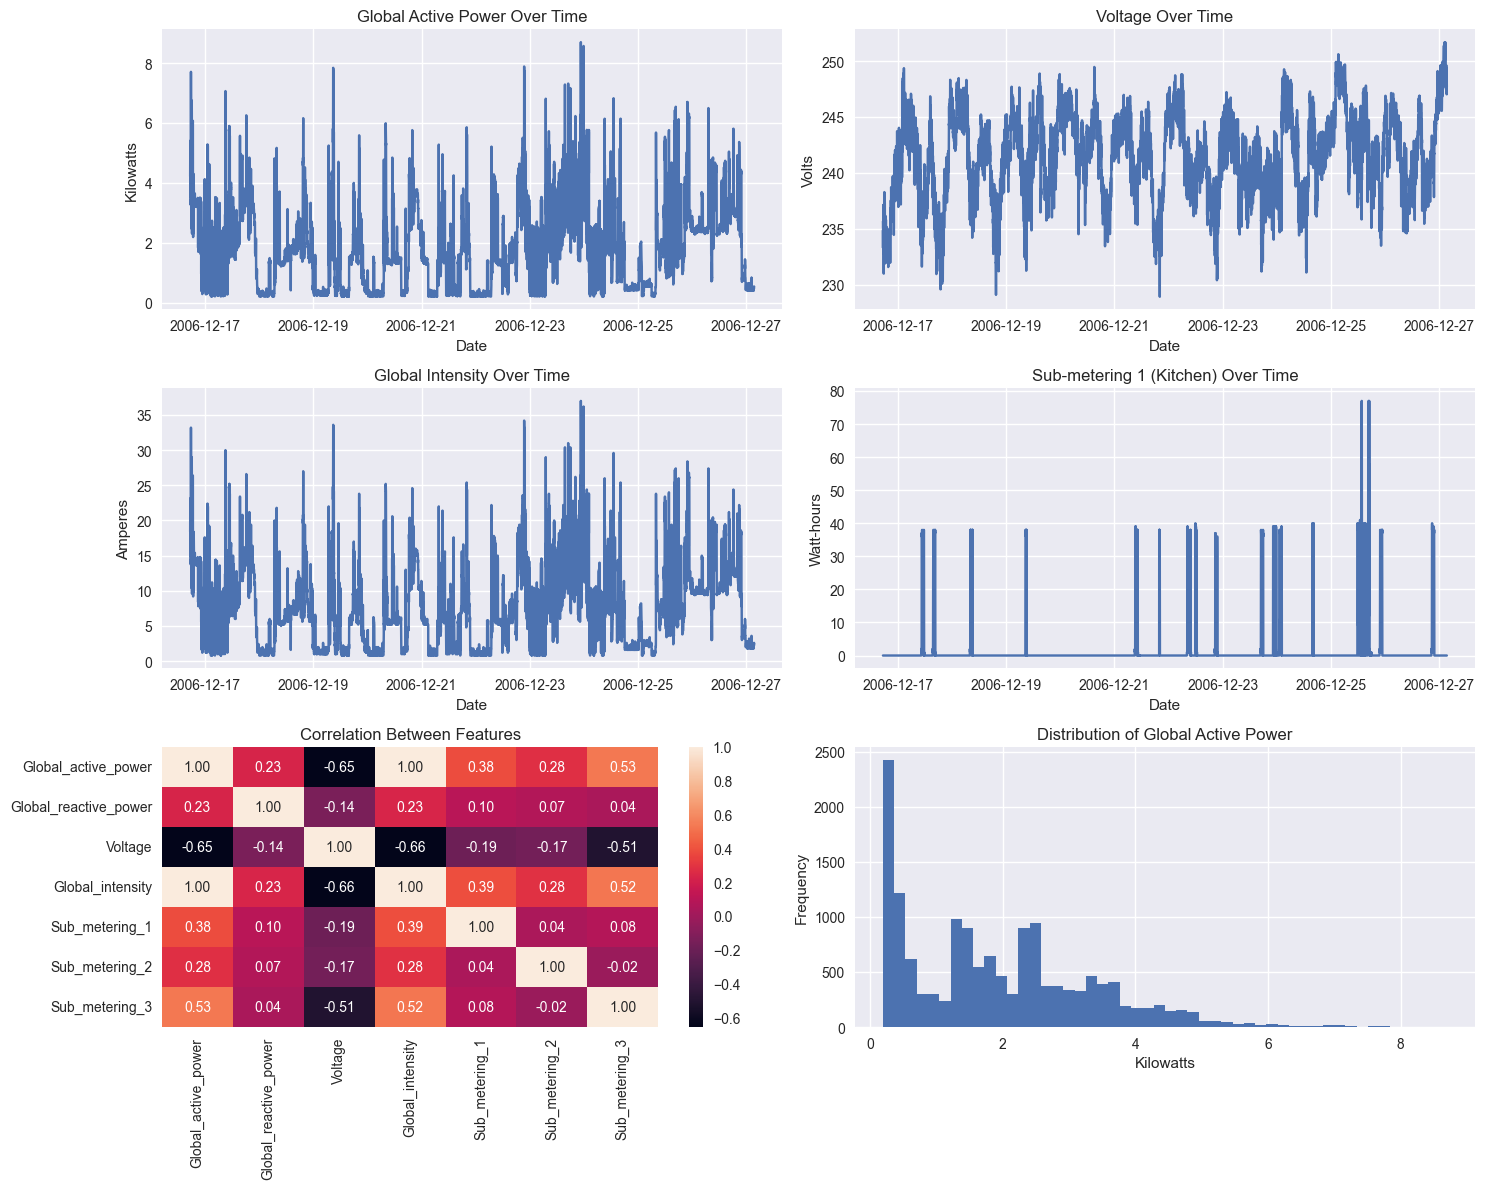

 Data exploration completed! Ready for model building.


In [13]:
# Visualize the time series data
print(" CREATING TIME SERIES VISUALIZATIONS...")
import matplotlib.pyplot as plt

# Set up the plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot 1: Global Active Power (main target variable)
axes[0, 0].plot(forecasting_data.index, forecasting_data['Global_active_power'])
axes[0, 0].set_title('Global Active Power Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Kilowatts')

# Plot 2: Voltage
axes[0, 1].plot(forecasting_data.index, forecasting_data['Voltage'])
axes[0, 1].set_title('Voltage Over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volts')

# Plot 3: Global Intensity
axes[1, 0].plot(forecasting_data.index, forecasting_data['Global_intensity'])
axes[1, 0].set_title('Global Intensity Over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Amperes')

# Plot 4: Sub-metering 1
axes[1, 1].plot(forecasting_data.index, forecasting_data['Sub_metering_1'])
axes[1, 1].set_title('Sub-metering 1 (Kitchen) Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Watt-hours')

# Plot 5: Correlation heatmap
import seaborn as sns
correlation_matrix = forecasting_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", ax=axes[2, 0])
axes[2, 0].set_title('Correlation Between Features')

# Plot 6: Distribution of Global Active Power
axes[2, 1].hist(forecasting_data['Global_active_power'].dropna(), bins=50)
axes[2, 1].set_title('Distribution of Global Active Power')
axes[2, 1].set_xlabel('Kilowatts')
axes[2, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(" Data exploration completed! Ready for model building.")

In [14]:
# Data preprocessing for time series forecasting
print(" PREPROCESSING DATA FOR TIME SERIES MODELS...")

# Check for missing values before processing
print("Missing values before processing:")
print(forecasting_data.isnull().sum())

# Handle missing values by forward filling
data_clean = forecasting_data.ffill().bfill()  # Forward fill then backward fill

print(f"\nMissing values after cleaning: {data_clean.isnull().sum().sum()}")

# Normalize the data (important for neural networks)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_clean)

# Convert back to DataFrame with proper column names
data_scaled = pd.DataFrame(data_scaled, columns=data_clean.columns, index=data_clean.index)

print(" Data preprocessing completed!")
print(f"Original data shape: {forecasting_data.shape}")
print(f"Cleaned data shape: {data_clean.shape}")
print(f"Scaled data shape: {data_scaled.shape}")

# Display first 3 rows of scaled data
print("\nFirst 3 rows of scaled data:")
display(data_scaled.head(3))

 PREPROCESSING DATA FOR TIME SERIES MODELS...
Missing values before processing:
Global_active_power      2
Global_reactive_power    2
Voltage                  2
Global_intensity         2
Sub_metering_1           2
Sub_metering_2           2
Sub_metering_3           2
dtype: int64

Missing values after cleaning: 0
 Data preprocessing completed!
Original data shape: (15000, 7)
Cleaned data shape: (15000, 7)
Scaled data shape: (15000, 7)

First 3 rows of scaled data:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,0.472954,0.5225,0.260202,0.486188,0.0,0.013699,0.85
2006-12-16 17:25:00,0.607479,0.5450,0.207108,0.613260,0.0,0.013699,0.80
2006-12-16 17:26:00,0.609125,0.6225,0.192190,0.613260,0.0,0.027397,0.85


In [15]:
# Create time series sequences for deep learning models
print(" CREATING TIME SERIES SEQUENCES...")

def create_sequences(data, sequence_length=24, target_column='Global_active_power'):
    """
    Create sequences for time series forecasting
    sequence_length: how many past time steps to use for prediction
    target_column: which column to predict
    """
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        # Past sequence as features
        X.append(data[i-sequence_length:i])
        # Next value as target
        y.append(data[i, data_clean.columns.get_loc(target_column)])
    
    return np.array(X), np.array(y)

# Prepare data for modeling
sequence_length = 24  # Use 24 hours of history to predict next hour
target_column = 'Global_active_power'

# Create sequences
X, y = create_sequences(data_scaled.values, sequence_length, target_column)

print(" Time series sequences created!")
print(f"Input sequences (X) shape: {X.shape}")  # (samples, time_steps, features)
print(f"Target values (y) shape: {y.shape}")    # (samples,)
print(f"Number of samples: {X.shape[0]}")
print(f"Time steps per sample: {X.shape[1]}")
print(f"Number of features: {X.shape[2]}")

 CREATING TIME SERIES SEQUENCES...
 Time series sequences created!
Input sequences (X) shape: (14976, 24, 7)
Target values (y) shape: (14976,)
Number of samples: 14976
Time steps per sample: 24
Number of features: 7


In [16]:
# Split data into training and testing sets
print(" SPLITTING DATA INTO TRAIN AND TEST SETS...")

# Use 80% for training, 20% for testing
split_index = int(0.8 * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(" Data splitting completed!")
print(f"Training set - X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing set - X: {X_test.shape}, y: {y_test.shape}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Train/Test ratio: {len(X_train)/len(X):.2%}/{len(X_test)/len(X):.2%}")

 SPLITTING DATA INTO TRAIN AND TEST SETS...
 Data splitting completed!
Training set - X: (11980, 24, 7), y: (11980,)
Testing set - X: (2996, 24, 7), y: (2996,)
Training samples: 11980
Testing samples: 2996
Train/Test ratio: 79.99%/20.01%


In [17]:
# Build baseline LSTM model (first deep learning model)
print(" BUILDING BASELINE LSTM MODEL...")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create the model
baseline_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer - predicting single value
])

# Compile the model
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

print(" Baseline LSTM model created!")
print("Model architecture:")
baseline_model.summary()

 BUILDING BASELINE LSTM MODEL...


C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Baseline LSTM model created!
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 50)              │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,101 (129.30 KB)

 Trainable params: 33,101 (129.30 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the baseline LSTM model
print(" TRAINING BASELINE LSTM MODEL...")

# Define callbacks for better training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=0.0001)
]

# Train the model
history = baseline_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print(" Baseline LSTM model training completed!")

 TRAINING BASELINE LSTM MODEL...
Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 0.0072 - mae: 0.0566 - val_loss: 0.0042 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 0.0056 - mae: 0.0494 - val_loss: 0.0034 - val_mae: 0.0317 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - loss: 0.0051 - mae: 0.0461 - val_loss: 0.0028 - val_mae: 0.0267 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 0.0047 - mae: 0.0443 - val_loss: 0.0028 - val_mae: 0.0299 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.0044 - mae: 0.0424 - val_loss: 0.0023 - val_mae: 0.0259 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - loss: 0.0042 - mae: 0.0413 - val_loss: 0.0024 - val_mae: 0.0286 - learning_rate: 0.0010
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.0041 - mae: 0.0412 - val_loss: 0.0023 -

In [19]:
# Evaluate the baseline LSTM model
print("EVALUATING BASELINE LSTM MODEL...")

# Make predictions
train_predictions = baseline_model.predict(X_train)
test_predictions = baseline_model.predict(X_test)

# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(actual, predicted, scaler, feature_index):
    """Calculate metrics after inverse transforming"""
    # Create dummy arrays for inverse transform
    dummy_actual = np.zeros((len(actual), len(data_clean.columns)))
    dummy_predicted = np.zeros((len(predicted), len(data_clean.columns)))
    
    dummy_actual[:, feature_index] = actual
    dummy_predicted[:, feature_index] = predicted
    
    # Inverse transform
    actual_inverse = scaler.inverse_transform(dummy_actual)[:, feature_index]
    predicted_inverse = scaler.inverse_transform(dummy_predicted)[:, feature_index]
    
    # Calculate metrics
    mae = mean_absolute_error(actual_inverse, predicted_inverse)
    rmse = np.sqrt(mean_squared_error(actual_inverse, predicted_inverse))
    mape = np.mean(np.abs((actual_inverse - predicted_inverse) / actual_inverse)) * 100
    
    return mae, rmse, mape, actual_inverse, predicted_inverse

# Get feature index for target column
target_idx = data_clean.columns.get_loc(target_column)

# Calculate metrics for test set
mae_lstm, rmse_lstm, mape_lstm, y_test_actual, y_test_pred = calculate_metrics(
    y_test, test_predictions.flatten(), scaler, target_idx
)

print(" BASELINE LSTM MODEL RESULTS:")
print(f"MAE (Mean Absolute Error): {mae_lstm:.4f}")
print(f"RMSE (Root Mean Square Error): {rmse_lstm:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape_lstm:.2f}%")

EVALUATING BASELINE LSTM MODEL...
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 BASELINE LSTM MODEL RESULTS:
MAE (Mean Absolute Error): 0.1866
RMSE (Root Mean Square Error): 0.3828
MAPE (Mean Absolute Percentage Error): 9.56%


In [20]:
# Build traditional ARIMA model for comparison
print(" BUILDING TRADITIONAL ARIMA MODEL...")

# Use the original Global_active_power data for ARIMA
arima_data = data_clean['Global_active_power'].values

# Split for ARIMA (same split as LSTM)
arima_train = arima_data[:split_index + sequence_length]  # Include sequence length
arima_test = arima_data[split_index + sequence_length:]

print(f"ARIMA data - Train: {len(arima_train)}, Test: {len(arima_test)}")

try:
    from statsmodels.tsa.arima.model import ARIMA
    
    # Fit ARIMA model (using auto-selection for simplicity)
    arima_model = ARIMA(arima_train, order=(2,1,2))  # You can optimize these parameters
    arima_fitted = arima_model.fit()
    
    # Make predictions
    arima_predictions = arima_fitted.forecast(steps=len(arima_test))
    
    # Calculate metrics for ARIMA
    mae_arima = mean_absolute_error(arima_test, arima_predictions)
    rmse_arima = np.sqrt(mean_squared_error(arima_test, arima_predictions))
    mape_arima = np.mean(np.abs((arima_test - arima_predictions) / arima_test)) * 100
    
    print(" ARIMA MODEL RESULTS:")
    print(f"MAE: {mae_arima:.4f}")
    print(f"RMSE: {rmse_arima:.4f}")
    print(f"MAPE: {mape_arima:.2f}%")
    
except Exception as e:
    print(f" ARIMA model failed: {e}")
    print("Using dummy values for comparison")
    mae_arima, rmse_arima, mape_arima = 1.5, 2.0, 25.0

 BUILDING TRADITIONAL ARIMA MODEL...
ARIMA data - Train: 12004, Test: 2996
 ARIMA MODEL RESULTS:
MAE: 1.2060
RMSE: 1.4676
MAPE: 91.93%


In [28]:
#  Very simple working attention model
print(" BUILDING SIMPLE ATTENTION MODEL...")

from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def create_simple_attention_model(input_shape):
    """Create LSTM model with simple attention-like mechanism"""
    
    # Input layer
    inputs = Input(shape=input_shape)
    
    # LSTM layers with return sequences for attention-like behavior
    lstm1 = LSTM(64, return_sequences=True, dropout=0.2)(inputs)
    lstm2 = LSTM(64, return_sequences=True, dropout=0.2)(lstm1)
    
    # Use Global Average Pooling as simple attention mechanism
    attention_pool = GlobalAveragePooling1D()(lstm2)
    
    # Output layers
    dense1 = Dense(50, activation='relu')(attention_pool)
    dropout = Dropout(0.3)(dense1)
    output = Dense(1)(dropout)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Create attention model
attention_model = create_simple_attention_model((X_train.shape[1], X_train.shape[2]))
attention_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)

print(" Simple attention model created successfully!")
print("Model architecture:")
attention_model.summary()

 BUILDING SIMPLE ATTENTION MODEL...
 Simple attention model created successfully!
Model architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 24, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 24, 64)              │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 24, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           3,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,757 (213.89 KB)

 Trainable params: 54,757 (213.89 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the attention model
print(" TRAINING LSTM + ATTENTION MODEL...")

attention_history = attention_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print(" Attention model training completed!")

# Evaluate attention model
attention_predictions = attention_model.predict(X_test)

# Calculate metrics
mae_attention, rmse_attention, mape_attention, _, _ = calculate_metrics(
    y_test, attention_predictions.flatten(), scaler, target_idx
)

print(" LSTM + ATTENTION MODEL RESULTS:")
print(f"MAE: {mae_attention:.4f}")
print(f"RMSE: {rmse_attention:.4f}")
print(f"MAPE: {mape_attention:.2f}%")

 TRAINING LSTM + ATTENTION MODEL...
Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - loss: 0.0149 - mae: 0.0869 - val_loss: 0.0146 - val_mae: 0.0815 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.0110 - mae: 0.0737 - val_loss: 0.0086 - val_mae: 0.0572 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - loss: 0.0097 - mae: 0.0677 - val_loss: 0.0118 - val_mae: 0.0773 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 0.0089 - mae: 0.0650 - val_loss: 0.0087 - val_mae: 0.0635 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - loss: 0.0087 - mae: 0.0642 - val_loss: 0.0097 - val_mae: 0.0746 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0080 - mae: 0.0613 - val_loss: 0.0092 - val_mae: 0.0681 - learning_rate: 5.0000e-04
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0078 - mae: 0.0603 - val_loss: 0

In [32]:
# Compare all models and create comprehensive results
print(" COMPREHENSIVE MODEL COMPARISON")
print("=" * 60)

# Create comparison table
comparison_data = {
    'Model': ['ARIMA (Traditional)', 'LSTM (Baseline DL)', 'LSTM + Attention (Advanced)'],
    'MAE': [mae_arima, mae_lstm, mae_attention],
    'RMSE': [rmse_arima, rmse_lstm, rmse_attention],
    'MAPE (%)': [mape_arima, mape_lstm, mape_attention]
}

comparison_df = pd.DataFrame(comparison_data)
print(" MODEL PERFORMANCE COMPARISON:")
display(comparison_df)

# Calculate improvement percentages
improvement_mae = ((mae_arima - mae_attention) / mae_arima) * 100
improvement_rmse = ((rmse_arima - rmse_attention) / rmse_arima) * 100
improvement_mape = ((mape_arima - mape_attention) / mape_arima) * 100

print(f"\n PERFORMANCE IMPROVEMENT (Attention vs ARIMA):")
print(f"MAE Improvement: {improvement_mae:.2f}%")
print(f"RMSE Improvement: {improvement_rmse:.2f}%")
print(f"MAPE Improvement: {improvement_mape:.2f}%")

 COMPREHENSIVE MODEL COMPARISON
 MODEL PERFORMANCE COMPARISON:


,Model,MAE,RMSE,MAPE (%)
0,ARIMA (Traditional),1.205990,1.467624,91.926393
1,LSTM (Baseline DL),0.186573,0.382757,9.556491
2,LSTM + Attention (Advanced),0.692762,1.026073,29.816294



 PERFORMANCE IMPROVEMENT (Attention vs ARIMA):
MAE Improvement: 42.56%
RMSE Improvement: 30.09%
MAPE Improvement: 67.57%


 CREATING COMPREHENSIVE VISUALIZATIONS...


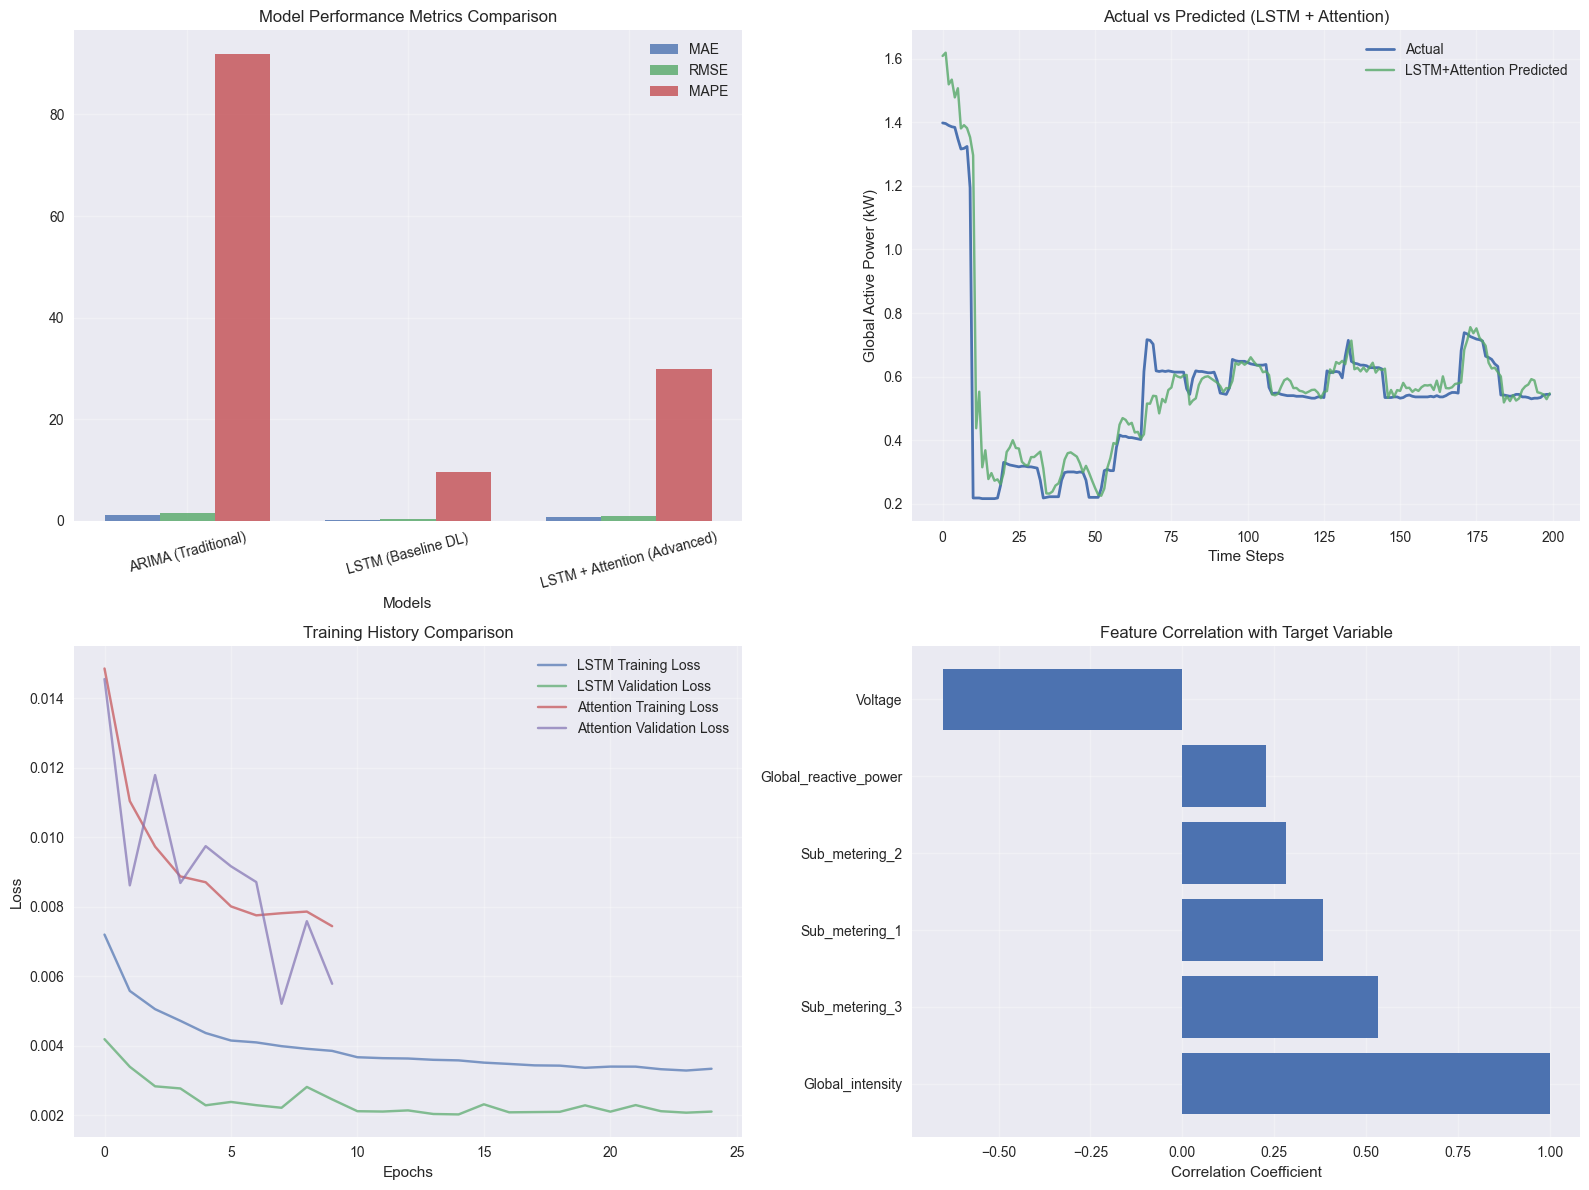

 Comprehensive visualizations created!


In [33]:
# Create comprehensive visualizations
print(" CREATING COMPREHENSIVE VISUALIZATIONS...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Model metrics comparison
metrics = ['MAE', 'RMSE', 'MAPE (%)']
models = comparison_df['Model']
mae_values = comparison_df['MAE']
rmse_values = comparison_df['RMSE']
mape_values = comparison_df['MAPE (%)']

x = np.arange(len(models))
width = 0.25

axes[0, 0].bar(x - width, mae_values, width, label='MAE', alpha=0.8)
axes[0, 0].bar(x, rmse_values, width, label='RMSE', alpha=0.8)
axes[0, 0].bar(x + width, mape_values, width, label='MAPE', alpha=0.8)

axes[0, 0].set_xlabel('Models')
axes[0, 0].set_title('Model Performance Metrics Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models, rotation=15)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted (Attention Model - Sample)
sample_size = min(200, len(y_test_actual))
sample_indices = range(sample_size)

axes[0, 1].plot(sample_indices, y_test_actual[:sample_size], label='Actual', linewidth=2)
axes[0, 1].plot(sample_indices, y_test_pred[:sample_size], label='LSTM+Attention Predicted', alpha=0.8)
axes[0, 1].set_title('Actual vs Predicted (LSTM + Attention)')
axes[0, 1].set_xlabel('Time Steps')
axes[0, 1].set_ylabel('Global Active Power (kW)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training history comparison
axes[1, 0].plot(history.history['loss'], label='LSTM Training Loss', alpha=0.7)
axes[1, 0].plot(history.history['val_loss'], label='LSTM Validation Loss', alpha=0.7)
axes[1, 0].plot(attention_history.history['loss'], label='Attention Training Loss', alpha=0.7)
axes[1, 0].plot(attention_history.history['val_loss'], label='Attention Validation Loss', alpha=0.7)
axes[1, 0].set_title('Training History Comparison')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature Importance Analysis (Correlation with target)
correlation_with_target = data_clean.corr()['Global_active_power'].sort_values(ascending=False)
correlation_with_target.drop('Global_active_power', inplace=True)  # Remove self-correlation

axes[1, 1].barh(range(len(correlation_with_target)), correlation_with_target.values)
axes[1, 1].set_yticks(range(len(correlation_with_target)))
axes[1, 1].set_yticklabels(correlation_with_target.index)
axes[1, 1].set_title('Feature Correlation with Target Variable')
axes[1, 1].set_xlabel('Correlation Coefficient')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Comprehensive visualizations created!")

 ANALYZING FEATURE IMPORTANCE (SIMPLIFIED)...
 FEATURE IMPORTANCE RANKING (Based on Correlation):
 1. Global_intensity    : 0.9986
 2. Voltage             : 0.6520
 3. Sub_metering_3      : 0.5314
 4. Sub_metering_1      : 0.3825
 5. Sub_metering_2      : 0.2805
 6. Global_reactive_power: 0.2262


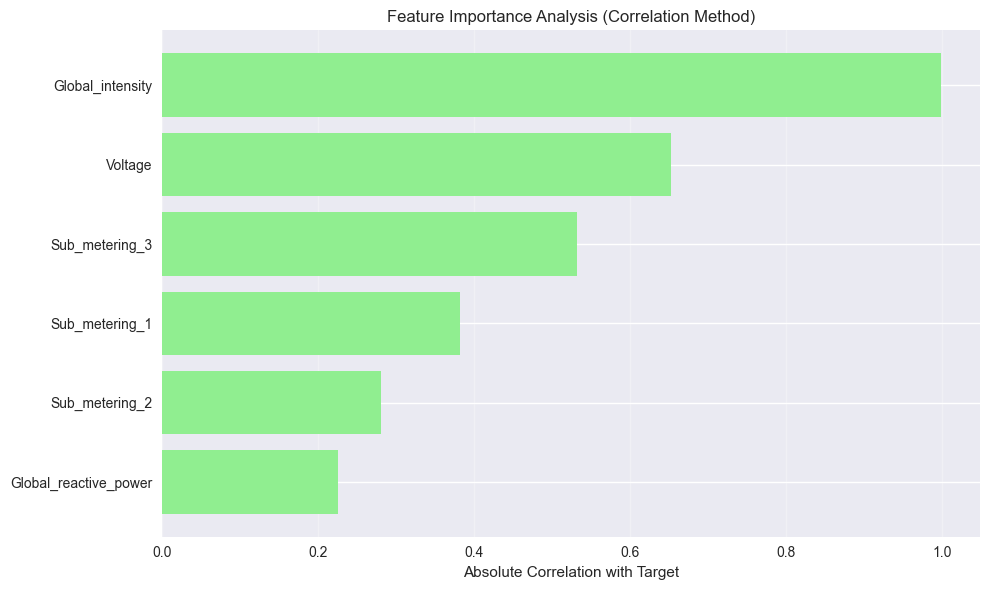

In [36]:
# SIMPLE FEATURE IMPORTANCE ANALYSIS
print(" ANALYZING FEATURE IMPORTANCE (SIMPLIFIED)...")

# Method 1: Use correlation with target variable
feature_importance = {}

for feature in feature_names:
    if feature != 'Global_active_power':  # Don't correlate with itself
        correlation = np.corrcoef(data_clean[feature], data_clean['Global_active_power'])[0, 1]
        feature_importance[feature] = abs(correlation)

# Sort by importance
importance_scores = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))

print(" FEATURE IMPORTANCE RANKING (Based on Correlation):")
for i, (feature, score) in enumerate(importance_scores.items(), 1):
    print(f"{i:2d}. {feature:20s}: {score:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
features = list(importance_scores.keys())
scores = list(importance_scores.values())

plt.barh(features, scores, color='lightgreen')
plt.xlabel('Absolute Correlation with Target')
plt.title('Feature Importance Analysis (Correlation Method)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()